#1 Trade Logic & Risk Control Basics

1.1

Leverage shows how much of your available money you actually use in a trade. If leverage is less than 1, it means you’re only using part of your money, not everything you have. This can be smart in markets that swing a lot, because you avoid risking all your cash at once. It also leaves some money free so you can spread it over different trades. The downside is that some of your money sits unused.

In our backtesting tool, we only use simple signals: buy (+1), sell (–1), or do nothing (0). But in real life, you often vary how big your position is—buying more when you feel confident, or less when you’re unsure. To mimic that, we can apply leverage to size positions. For example, if the trend looks weak, we might use less leverage (smaller position). If the trend seems strong, we use more leverage (bigger position). This way, our simulated stakes go up and down depending on how clear the signal is, similar to real trading.

Static stop-loss: You pick a price level when you open the trade. If the market hits that level or goes below it, you exit. That set level never changes, no matter how the price moves.

Trailing stop-loss: This one moves up if the price goes up, following the trend. It never moves down. So if the price rises, your stop-loss moves up too. If the price later drops enough to hit your trailing level, you exit—often at a higher point than your original stop. This helps lock in gains if the trend reverses.

1.2

In a smooth, steadily rising market, a trailing stop can lock in profits when the trend turns, but if it’s too tight (set too close to current price), small dips might trigger it prematurely. A static stop is less sensitive to those small ups and downs, but if the trend turns sharply, you might miss locking in early gains because your stop stays where you set it.

In a choppy or very volatile market, a trailing stop might get hit by random swings before the price continues upward, while a static stop sits farther from current price (if set wide enough) and might not trigger as often. But if a real reversal happens, the static stop might be too far and let profits slip away. So there’s a trade-off: tighter stops protect gains sooner but risk early exit on noise; looser stops avoid noise but risk losing gains if the trend reverses.

1.3

A “trailing take-profit” is basically a trailing stop that only starts moving after you’ve already hit your initial profit target. In practice, you don’t need a completely separate system for it—once your first target is met, you switch on the trailing stop. Functionally, it behaves like a trailing stop-loss that activates only after you see some profit.

1.4

Sometimes a trade doesn’t close right at your stop level. Common reasons in simple terms:

* **Slippage or low liquidity**: In fast-moving or thin markets, the price can jump past your stop before the order executes. Your order might fill at a worse price or not fill if there aren’t enough buyers/sellers at that exact level.
* **Gaps (overnight or news-driven)**: If the market reopens at a price beyond your stop (e.g., you set a stop at \$50 but it opens at \$45), it can’t execute at \$50. It may fill at the next available price or not at all if it’s a strict limit.
* **Processing delays**: Technical or broker delays can mean your stop order isn’t sent or handled instantly, so price can dip below the stop before the exit happens.


#2: Probabilistic Pattern Validator

In [83]:
!pip install numpy pandas yfinance mplfinance matplotlib --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf



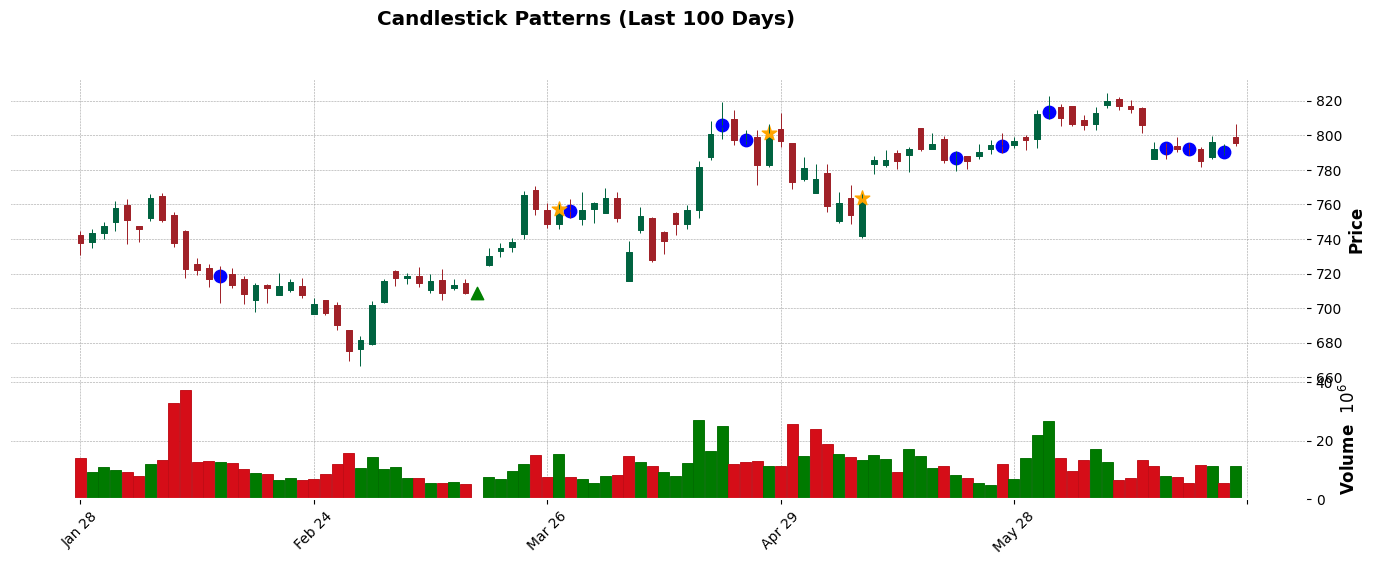

In [84]:
data = yf.download('SBIN.NS', period='5y', interval='1d',auto_adjust=True, progress=False)
data.head()


data.reset_index(inplace=True)
data.columns = [col if not isinstance(col, tuple) else col[0] for col in data.columns]
data.head()

# 1. Pattern identification functions
def is_doji(open_, high, low, close):
    body = abs(close - open_)
    total_range = high - low
    # Doji if body is less than 10% of range
    return body < 0.1 * total_range

def is_hammer(open_, high, low, close):
    body = abs(close - open_)
    total_range = high - low
    lower_wick = min(open_, close) - low
    upper_wick = high - max(open_, close)
    return (
        body <= 0.1 * total_range
        and lower_wick >= 2 * body
        and upper_wick <= 0.1 * total_range
    )

def is_bullish_engulfing(prev_open, prev_close, curr_open, curr_close):
    return (
        (prev_close < prev_open)
        and (curr_close > curr_open)
        and (curr_open < prev_close)
        and (curr_close > prev_open)
    )

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


data['Doji'] = data.apply(
    lambda row: is_doji(row['Open'], row['High'], row['Low'], row['Close']),
    axis=1
)
data['Hammer'] = data.apply(
    lambda row: is_hammer(row['Open'], row['High'], row['Low'], row['Close']),
    axis=1
)

prev_open = data['Open'].shift(1)
prev_close = data['Close'].shift(1)
curr_open = data['Open']
curr_close = data['Close']

data['Bullish_Engulfing'] = (
    (prev_close < prev_open)
    & (curr_close > curr_open)
    & (curr_open < prev_close)
    & (curr_close > prev_open)
)

data['Bullish_Engulfing'].fillna(False, inplace=True)

data_recent = data.tail(100)

doji_plot = mpf.make_addplot(
    data_recent['Close'].where(data_recent['Doji']),
    type='scatter',
    markersize=80,
    marker='o',
    color='blue',
    panel=0
)

hammer_plot = mpf.make_addplot(
    data_recent['Close'].where(data_recent['Hammer']),
    type='scatter',
    markersize=80,
    marker='^',
    color='green',
    panel=0
)

engulfing_plot = mpf.make_addplot(
    data_recent['Close'].where(data_recent['Bullish_Engulfing']),
    type='scatter',
    markersize=120,
    marker='*',
    color='orange',
    panel=0
)

mpf.plot(
    data_recent,
    type='candle',
    style='charles',
    volume=True,
    addplot=[doji_plot, hammer_plot, engulfing_plot],
    title='Candlestick Patterns (Last 100 Days)',
    figsize=(18, 6)
)

2.2


In [85]:
def compute_win_rate(df, pattern_col, days_ahead):
    future_close = df['Close'].shift(-days_ahead)
    mask = df[pattern_col] & future_close.notna()
    total = mask.sum()
    if total == 0:
        return 0
    wins = (future_close[mask] > df['Close'][mask]).sum()
    return wins / total * 100


2.3


In [86]:
def compute_win_rate(df, pattern_col, days_ahead):
    future_close = df['Close'].shift(-days_ahead)
    mask = df[pattern_col] & future_close.notna()
    total = mask.sum()
    if total == 0:
        return 0
    wins = (future_close[mask] > df['Close'][mask]).sum()
    return wins / total * 100

def baseline_win_rate(df, days_ahead, sample_size):
    valid_range = len(df) - days_ahead
    indices = np.random.choice(valid_range, sample_size, replace=False)
    future = df['Close'].values[indices + days_ahead]
    current = df['Close'].values[indices]
    wins = (future > current).sum()
    return wins / sample_size * 100

final_results = []
for pattern in ['Doji', 'Hammer', 'Bullish_Engulfing']:
    entry = {'Pattern': pattern}
    for n in [3, 5]:
        entry[f'n={n}'] = compute_win_rate(data, pattern, n)
    final_results.append(entry)

sample_size = int(data[['Doji', 'Hammer', 'Bullish_Engulfing']].sum(axis=0).mean())
baseline_entry = {
    'Pattern': 'Baseline',
    'n=3': baseline_win_rate(data, 3, sample_size),
    'n=5': baseline_win_rate(data, 5, sample_size)
}

df_results = pd.DataFrame([baseline_entry] + final_results)

2.4[link text](https://)

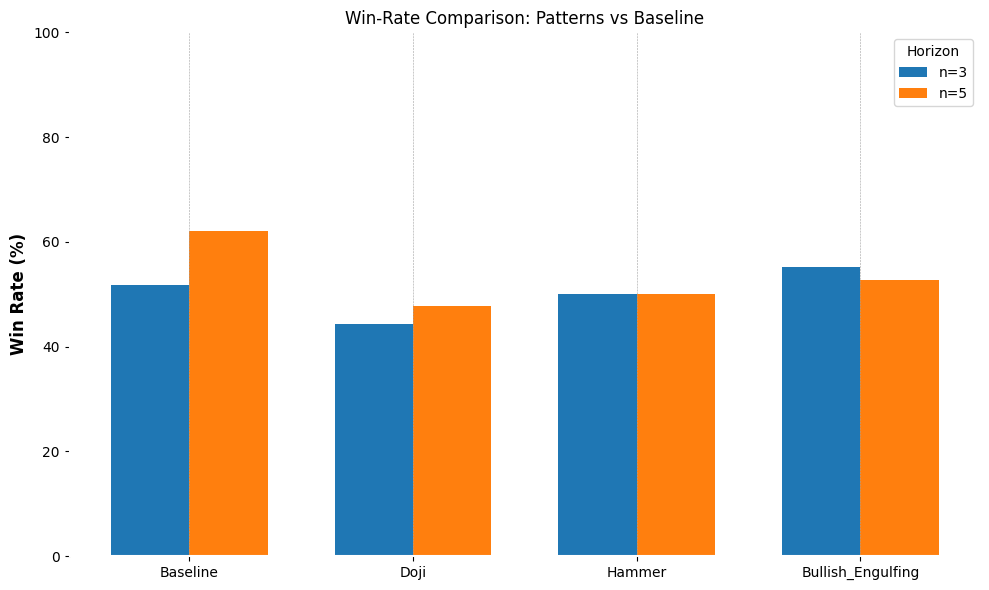

In [87]:
patterns = df_results['Pattern'].tolist()
horizons = [col for col in df_results.columns if col != 'Pattern']
values = [df_results[h].tolist() for h in horizons]

x = np.arange(len(patterns))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
for i, (horizon, vals) in enumerate(zip(horizons, values)):
    ax.bar(x + i * width, vals, width, label=horizon)

ax.set_xticks(x + width * (len(horizons) - 1) / 2)
ax.set_xticklabels(patterns)
ax.set_ylim(0, 100)
ax.set_ylabel('Win Rate (%)')
ax.set_title('Win-Rate Comparison: Patterns vs Baseline')
ax.legend(title='Horizon')
ax.grid(axis='y')

plt.tight_layout()
plt.show()


1. If a candlestick pattern beats the baseline in both the short and slightly longer term, it might offer a real advantage. But to be confident, we need plenty of examples and a method to check how much the results could vary.

2. Looking 5 days ahead instead of 3 smooths out quick ups and downs but can miss fast moves. That means win rates may look steadier or shift when we change how many days we check.

3. When a pattern—like the Hammer—shows almost the same win rate for both 3-day and 5-day checks, it suggests the signal is dependable. In other words, it seems to catch real reversals rather than just random changes, whether we look a little way ahead or a bit longer.


#3. Strategy X- Visual Interpretation and Implementation

3.1 Chart Interpretation:

**Key Signals**

* **Heiken Ashi candles** smooth out price swings to show trend direction more clearly (bullish ones often lack a lower wick; bearish lack an upper wick).
* **Supertrend (10,3)** flips between green (uptrend) and red (downtrend).
* **Money Flow Index (MFI, 14)** tracks buying vs. selling pressure around the midpoint (50): moving above 50 hints at more buying; moving below hints at more selling.

**Entry Rules**

* **Buy** when Supertrend turns green, Heiken Ashi looks bullish, and MFI is climbing (ideally crosses above 50). Enter at the close of the next candle.
* **Sell** when Supertrend turns red, Heiken Ashi looks bearish, and MFI is falling (ideally crosses below 50). Enter at the close of the next candle.

**Exit Rules**

* **Close long** if Supertrend flips red, or MFI drops from higher levels back toward or below 50, or you spot a bearish Heiken Ashi reversal (red candle with a noticeable upper wick).
* **Close short** if Supertrend flips green, or MFI rises from low levels toward 50, or you see a bullish Heiken Ashi reversal (green candle with a noticeable lower wick).


3.2 Entry and Exit Rules:

**Buy (Long) Entry**
Open a buy trade when:

* The Supertrend line switches to green.
* Heiken Ashi candles look bullish (green body with no lower shadow).
* The Money Flow Index is rising, ideally moving above 50.
  Enter at the close of the next candle after these three signs appear.

**Sell (Short) Entry**
Open a sell trade when:

* The Supertrend line switches to red.
* Heiken Ashi candles look bearish (red body with no upper shadow).
* The Money Flow Index is falling, ideally moving below 50.
  Enter at the close of the next candle after these three signs appear.

**Exit a Buy**
Close your buy trade when any of the following happens:

* Supertrend turns red.
* The Money Flow Index drops from higher levels (for example, moves down from above 60 toward or below 50).
* You see a bearish reversal candle on Heiken Ashi (a red candle with a long upper shadow).

**Exit a Sell**
Close your sell trade when any of the following happens:

* Supertrend turns green.
* The Money Flow Index rises from lower levels (for example, climbs from below 40 up toward 50).
* You see a bullish reversal candle on Heiken Ashi (a green candle with a long lower shadow).


3.3 Strategy Implementation and Backtest


/tmp/ipython-input-88-4099805399.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end, interval=interval, progress=False)


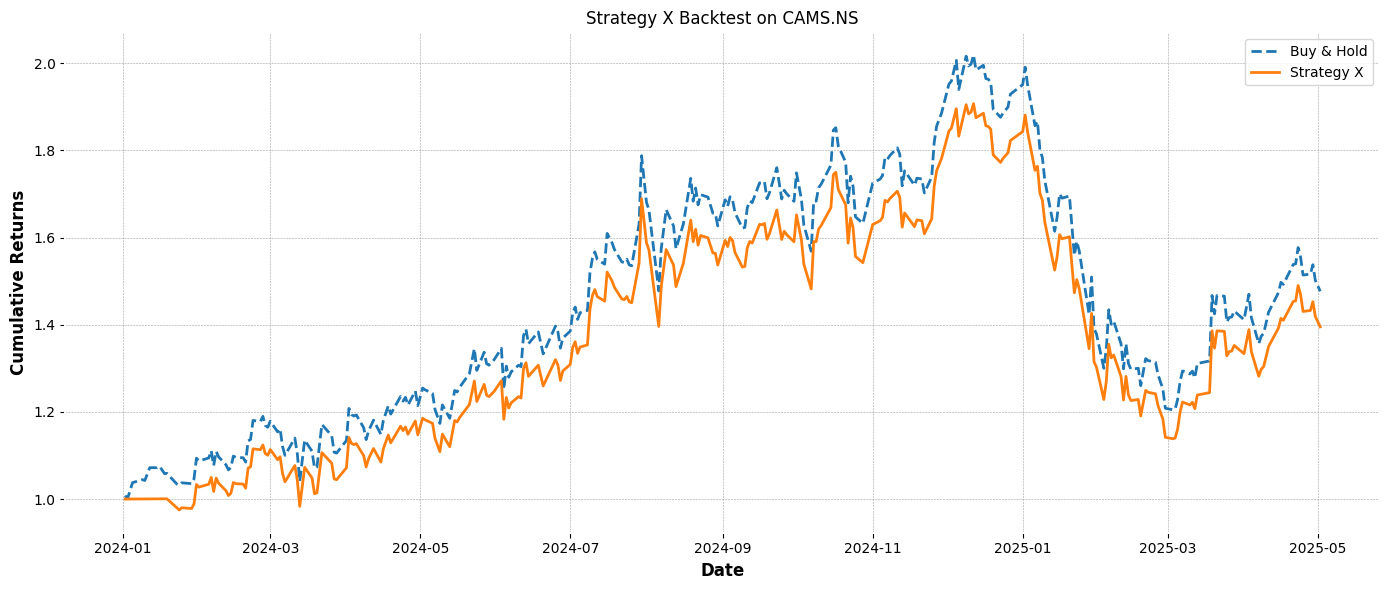

In [88]:
def fetch_data(symbol, start, end, interval):
    df = yf.download(symbol, start=start, end=end, interval=interval, progress=False)
    if isinstance(df.columns, pd.MultiIndex):
        try:
            df = df.xs(symbol, axis=1, level=1)
        except:
            df.columns = df.columns.get_level_values(-1)
    df.columns = [col.lower() for col in df.columns]
    df.index = pd.to_datetime(df.index)
    return df

def add_heiken_ashi(df):
    ha_close = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    ha_open = [(df['open'].iat[0] + df['close'].iat[0]) / 2]
    for i in range(1, len(df)):
        ha_open.append((ha_open[i - 1] + ha_close.iat[i - 1]) / 2)
    ha_open = pd.Series(ha_open, index=df.index)
    ha_high = pd.concat([ha_open, ha_close, df['high']], axis=1).max(axis=1)
    ha_low = pd.concat([ha_open, ha_close, df['low']], axis=1).min(axis=1)
    return df.assign(ha_open=ha_open, ha_high=ha_high, ha_low=ha_low, ha_close=ha_close)

def add_supertrend(df, period=10, multiplier=3):
    tr = df['high'] - df['low']
    atr = tr.rolling(period).mean()
    hl2 = (df['ha_high'] + df['ha_low']) / 2
    upper = hl2 + multiplier * atr
    lower = hl2 - multiplier * atr
    st = [True]
    for i in range(1, len(df)):
        if df['close'].iat[i] > upper.iat[i - 1]:
            st.append(True)
        elif df['close'].iat[i] < lower.iat[i - 1]:
            st.append(False)
        else:
            st.append(st[i - 1])
    return df.assign(supertrend=pd.Series(st, index=df.index))

def add_mfi(df, period=14):
    tp = (df['high'] + df['low'] + df['close']) / 3
    mf = tp * df['volume']
    diff = tp.diff()
    pos = mf.where(diff > 0, 0)
    neg = mf.where(diff <= 0, 0)
    roll_pos = pos.rolling(period).sum()
    roll_neg = neg.rolling(period).sum()
    mfi = 100 * roll_pos.divide(roll_pos + roll_neg)
    return df.assign(mfi=mfi)

def generate_signals(df):
    buy = df['supertrend'] & (df['mfi'] > 50)
    sell = (~df['supertrend']) & (df['mfi'] < 50)
    pos = pd.Series(0, index=df.index)
    for i in range(1, len(df)):
        if buy.iat[i]:
            pos.iat[i] = 1
        elif sell.iat[i]:
            pos.iat[i] = 0
        else:
            pos.iat[i] = pos.iat[i - 1]
    return df.assign(position=pos)

def backtest(df):
    ret = df['close'].pct_change()
    strat = df['position'].shift(1) * ret
    cum = (1 + pd.concat([ret, strat], axis=1)).cumprod()
    cum.columns = ['buy_hold', 'strategy']
    return cum

df = fetch_data('CAMS.NS', start='2024-01-01', end='2025-05-04', interval='1d')
df = add_heiken_ashi(df)
df = add_supertrend(df)
df = add_mfi(df)
df = generate_signals(df)
cum = backtest(df)

plt.figure(figsize=(14, 6))
plt.plot(cum['buy_hold'], linestyle='--', label='Buy & Hold')
plt.plot(cum['strategy'], label='Strategy X')
plt.title('Strategy X Backtest on CAMS.NS')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


3.4 Incorporating a Complementary Indicator

Strategy Y adds a volatility check to avoid false signals when the market is quiet.

Why use ATR?
Strategy X can misfire in low-action or sideways markets. ATR tells us how big recent price swings have been. We compare ATR to its own average: when ATR is above that average, volatility is rising and larger moves are more likely.

What is ATR?
ATR shows the typical high-to-low range over a set period (for example, 14 days). We then smooth ATR with a longer moving average (for example, 20 days). If the current ATR is above that moving average, it means volatility is picking up.

Entry rule (long only):

* Supertrend is green, showing an uptrend.
* MFI is over 50, meaning buying pressure is stronger.
* ATR is above its moving average, so swings are growing.
  Enter at the close of the next candle once all three are in place.

Exit rule (long):
Close the trade if any of these happens:

* Supertrend flips red, indicating the trend may reverse.
* MFI falls below 50, suggesting selling pressure is rising.
* ATR drops below its moving average, meaning volatility is fading.


/tmp/ipython-input-89-1725082704.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end, progress=False)
/tmp/ipython-input-89-1725082704.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['mfi'].fillna(method='bfill',inplace=True)
/tmp/ipython-input-89-1725082704.py:54: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['mfi'].fillna(method='bfill',inplace=Tru

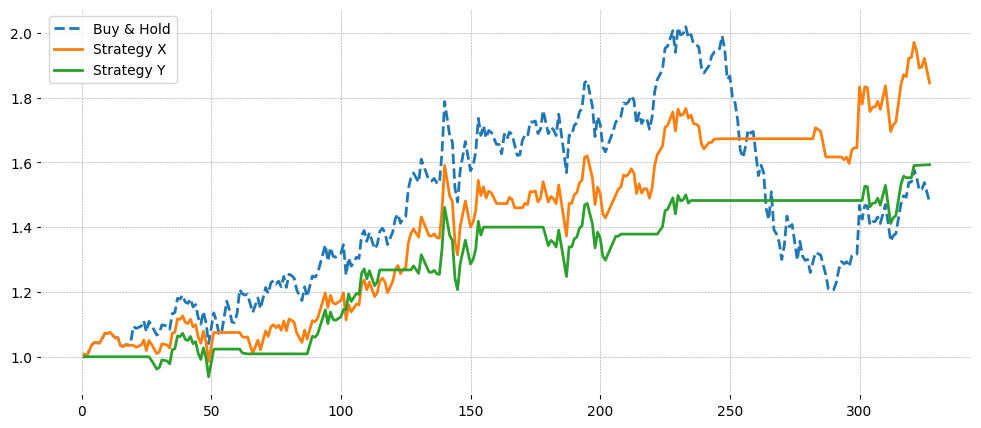

In [89]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def fetch_data(symbol, start, end):
    df = yf.download(symbol, start=start, end=end, progress=False)
    # Check if columns are a MultiIndex and flatten if necessary
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df.columns = df.columns.str.lower()
    df.index.name = 'datetime'
    # Keep only the relevant columns after lowercasing and flattening
    cols_to_keep = [col for col in df.columns if any(substring in col for substring in ['open', 'high', 'low', 'close', 'volume'])]
    df = df[cols_to_keep]
    return df.reset_index()

def heiken_ashi(df, symbol_suffix):
    ha_close = (df[f'open{symbol_suffix}'] + df[f'high{symbol_suffix}'] + df[f'low{symbol_suffix}'] + df[f'close{symbol_suffix}']) / 4
    ha_open = [(df[f'open{symbol_suffix}'].iat[0] + df[f'close{symbol_suffix}'].iat[0]) / 2]
    for i in range(1, len(df)):
        ha_open.append((ha_open[i - 1] + ha_close.iat[i - 1]) / 2)
    ha_open = pd.Series(ha_open, index=df.index)
    ha_high = pd.concat([ha_open, ha_close, df[f'high{symbol_suffix}']], axis=1).max(axis=1)
    ha_low = pd.concat([ha_open, ha_close, df[f'low{symbol_suffix}']], axis=1).min(axis=1)
    return df.assign(ha_open=ha_open, ha_high=ha_high, ha_low=ha_low, ha_close=ha_close)

def supertrend(df, symbol_suffix, n=10,m=3):
    tr=df[f'high{symbol_suffix}'].rolling(n).max()-df[f'low{symbol_suffix}'].rolling(n).min()
    atr=tr.rolling(n).mean()
    mid=(df['ha_high']+df['ha_low'])/2
    up=mid+m*atr
    dn=mid-m*atr
    st=[True]
    for i in range(1,len(df)):
        if df[f'close{symbol_suffix}'].iat[i]>up[i-1]: st.append(True)
        elif df[f'close{symbol_suffix}'].iat[i]<dn[i-1]: st.append(False)
        else: st.append(st[-1])
    df['trend']=['up' if x else 'down' for x in st]
    return df

def money_flow(df, symbol_suffix, n=14):
    tp=(df[f'high{symbol_suffix}']+df[f'low{symbol_suffix}']+df[f'close{symbol_suffix}'])/3
    mf=tp*df[f'volume{symbol_suffix}']
    diff = tp.diff()
    pos=[0];neg=[0]
    for i in range(1,len(tp)):
        if tp[i]>tp[i-1]: pos.append(mf[i]);neg.append(0)
        else: pos.append(0);neg.append(mf[i])
    rm=pd.Series(pos).rolling(n).sum()
    bm=pd.Series(neg).rolling(n).sum()
    # Avoid division by zero
    df['mfi']=100*(rm/(rm+bm).replace(0, np.nan))
    df['mfi'].fillna(method='bfill',inplace=True)
    return df

def average_true_range(df, symbol_suffix, n=14):
    hl=df[f'high{symbol_suffix}']-df[f'low{symbol_suffix}']
    hc=abs(df[f'high{symbol_suffix}']-df[f'close{symbol_suffix}'].shift())
    lc=abs(df[f'low{symbol_suffix}']-df[f'close{symbol_suffix}'].shift())
    tr=pd.concat([hl,hc,lc], axis=1).max(axis=1)
    atr=tr.rolling(n).mean()
    df['atr']=atr
    df['atr_sma']=atr.rolling(n).mean()
    return df

def generate_positions(df):
    df['entry_x']=(df['trend']=='up')&(df['mfi']>50)
    df['exit_x']=(df['trend']=='down')|(df['mfi']<50)
    df['entry_y']=df['entry_x']&(df['atr']>df['atr_sma'])
    df['exit_y']=df['exit_x']|(df['atr']<df['atr_sma'])
    pos_x=0;pos_y=0
    X=[];Y=[]
    for e_x,e_y,x_exit,y_exit in zip(df['entry_x'],df['entry_y'],df['exit_x'],df['exit_y']):
        if e_x: pos_x=1
        elif x_exit: pos_x=0
        if e_y: pos_y=1
        elif y_exit: pos_y=0
        X.append(pos_x);Y.append(pos_y)
    df['pos_x']=X;df['pos_y']=Y
    return df

def backtest(df, symbol_suffix):
    df['ret']=df[f'close{symbol_suffix}'].pct_change()
    df['strat_x']=df['pos_x'].shift()*df['ret']
    df['strat_y']=df['pos_y'].shift()*df['ret']
    return (1+df[['ret','strat_x','strat_y']]).cumprod()

symbol = 'CAMS.NS'
# Generate the symbol suffix with a leading underscore and lowercase symbol, preserving the period
symbol_suffix = f"_{symbol.lower()}"

c=fetch_data(symbol,'2024-01-01','2025-05-04')
ha=heiken_ashi(c.copy(), symbol_suffix)
st=supertrend(ha, symbol_suffix)
m=money_flow(st, symbol_suffix)
a=average_true_range(m, symbol_suffix) # Pass the output of money_flow to average_true_range
p=generate_positions(a) # Pass the output of average_true_range to generate_positions
r=backtest(p, symbol_suffix) # Pass the output of generate_positions to backtest


plt.figure(figsize=(12,5))
plt.plot(r['ret'],'--',label='Buy & Hold')
plt.plot(r['strat_x'],label='Strategy X')
plt.plot(r['strat_y'],label='Strategy Y')
plt.legend()
plt.show()

3.5  Strategy Enhancements:

**Where the current strategies stumble**

* **Flat, back-and-forth markets**
  Signals flip too often, money-flow hovers around the middle, and low volatility means fake entries and exits.
* **Low-volume periods**
  Volume-based filters break down, trend signals lag, and you end up sitting out true breakouts.
* **Big news gaps**
  Sudden jumps skip your trigger levels, so you enter late and hurt your risk-reward.

**Quick fixes to try**

1. **Dual-timeframe check**
   Only go long when both the daily and 4-hour Supertrend agree on direction.
2. **Strong-move filter**
   Require today’s ATR to top its highest reading over the past 20 days—only trade when volatility spikes.
3. **Volume surge rule**
   Trade only if today’s volume is at least 1.5× the 20-day average, to make sure there’s real interest.
4. **Trend confirmation**
   For longs, insist price sits above the 50-day EMA (and below it for shorts), so you stay with the main trend.
